<div align="center">
<h1>Tugas Besar Dasar Kecerdasan Artifisial</h1>
<h3>Prediksi Cuaca Menggunakan Fuzzy Mamdani dan Sugeno</h3>
<h4>Kelompok 6 - Semester Genap 2024/2025</h4>
</div>

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# 📌 1. Load dan Prapemrosesan Dataset

In [32]:
df = pd.read_csv("weatherHistory.csv", encoding='ISO-8859-1')
print(df.columns)
df = df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Summary']]
df.columns = ['temperature', 'humidity', 'windspeed', 'weather']

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')


# 📌 2. Handling Missing Value dan Outlier

Missing values sebelum penanganan:
temperature    0
humidity       0
windspeed      0
dtype: int64

Missing values setelah penanganan:
temperature    0
humidity       0
windspeed      0
dtype: int64


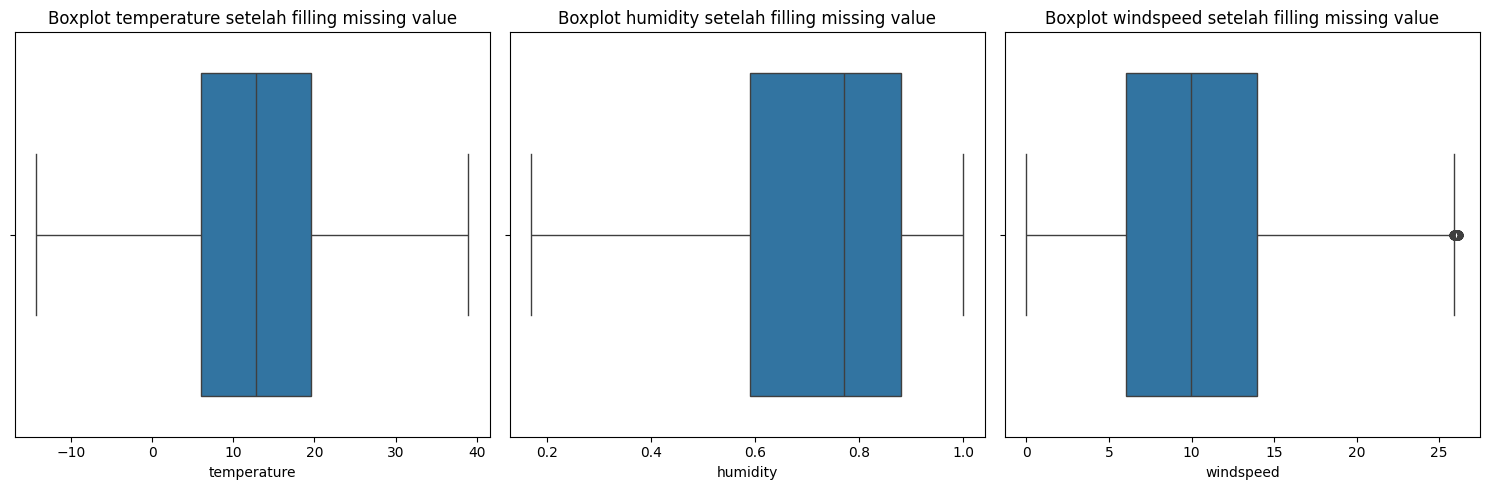


Jumlah data setelah menghapus outlier:
85573


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Tentukan kolom numerik
num_cols = ['temperature', 'humidity', 'windspeed']

# Cek missing value
print("Missing values sebelum penanganan:")
print(df[num_cols].isnull().sum())

# Handling missing value menggunakan median
for col in num_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)   # ✔ tanpa chained assignment

print("\nMissing values setelah penanganan:")
print(df[num_cols].isnull().sum())

# Visualisasi boxplot
plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[col])   # ✔ seaborn boxplot
    plt.title(f'Boxplot {col} setelah filling missing value')
plt.tight_layout()
plt.show()

# Menghapus Outlier dengan IQR
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

filter_condition = ~(
    (df[num_cols] < (Q1 - 1.5 * IQR)) |
    (df[num_cols] > (Q3 + 1.5 * IQR))
).any(axis=1)

df = df[filter_condition].reset_index(drop=True)

print("\nJumlah data setelah menghapus outlier:")
print(len(df))


# 📌 3. Normalisasi dan Encoding Label

In [46]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

top_labels = df['weather'].value_counts().head(4).index.tolist()
df = df[df['weather'].isin(top_labels)].reset_index(drop=True)

scaler = MinMaxScaler()
X = df[['temperature', 'humidity', 'windspeed']]
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df['weather'])
df['label'] = y

# 📌 4. Fungsi Keanggotaan Fuzzy

In [47]:
# 📌 Fungsi Keanggotaan Menggunakan trapmf

def trapmf(x, a, b, c, d):
    if x <= a or x >= d:
        return 0
    elif b <= x <= c:
        return 1
    elif a < x < b:
        return (x - a) / (b - a)
    elif c < x < d:
        return (d - x) / (d - c)

def fuzzy_suhu(x):
    return {
        'dingin': trapmf(x, 0, 0, 10, 20),
        'normal': trapmf(x, 15, 20, 25, 30),
        'panas': trapmf(x, 25, 30, 40, 40)
    }

def fuzzy_kelembapan(x):
    return {
        'rendah': trapmf(x, 0.0, 0.0, 0.2, 0.4),
        'sedang': trapmf(x, 0.3, 0.4, 0.6, 0.7),
        'tinggi': trapmf(x, 0.6, 0.7, 1.0, 1.0)
    }

def fuzzy_angin(x):
    return {
        'lemah': trapmf(x, 0, 0, 5, 10),
        'sedang': trapmf(x, 8, 12, 18, 22),
        'kencang': trapmf(x, 20, 25, 35, 35)
    }

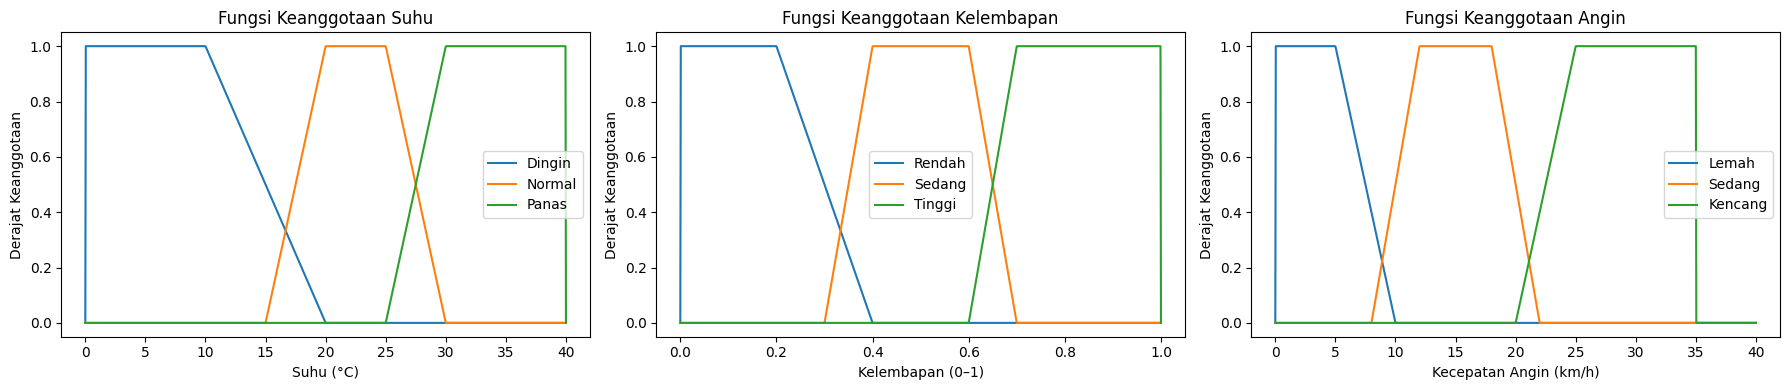

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def trapmf(x, a, b, c, d):
    return np.maximum(0, np.minimum(np.minimum((x - a) / (b - a + 1e-9), 1), (d - x) / (d - c + 1e-9)))

def plot_fuzzy_membership():
    # Range nilai
    x_suhu = np.linspace(0, 40, 1000)
    x_kelembapan = np.linspace(0, 1, 1000)
    x_angin = np.linspace(0, 40, 1000)

    # Suhu
    s_dingin = trapmf(x_suhu, 0, 0, 10, 20)
    s_normal = trapmf(x_suhu, 15, 20, 25, 30)
    s_panas = trapmf(x_suhu, 25, 30, 40, 40)

    # Kelembapan
    h_rendah = trapmf(x_kelembapan, 0.0, 0.0, 0.2, 0.4)
    h_sedang = trapmf(x_kelembapan, 0.3, 0.4, 0.6, 0.7)
    h_tinggi = trapmf(x_kelembapan, 0.6, 0.7, 1.0, 1.0)

    # Angin
    a_lemah = trapmf(x_angin, 0, 0, 5, 10)
    a_sedang = trapmf(x_angin, 8, 12, 18, 22)
    a_kencang = trapmf(x_angin, 20, 25, 35, 35)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Suhu
    axs[0].plot(x_suhu, s_dingin, label='Dingin')
    axs[0].plot(x_suhu, s_normal, label='Normal')
    axs[0].plot(x_suhu, s_panas, label='Panas')
    axs[0].set_title('Fungsi Keanggotaan Suhu')
    axs[0].set_xlabel('Suhu (°C)')
    axs[0].set_ylabel('Derajat Keanggotaan')
    axs[0].legend()

    # Kelembapan
    axs[1].plot(x_kelembapan, h_rendah, label='Rendah')
    axs[1].plot(x_kelembapan, h_sedang, label='Sedang')
    axs[1].plot(x_kelembapan, h_tinggi, label='Tinggi')
    axs[1].set_title('Fungsi Keanggotaan Kelembapan')
    axs[1].set_xlabel('Kelembapan (0–1)')
    axs[1].set_ylabel('Derajat Keanggotaan')
    axs[1].legend()

    # Angin
    axs[2].plot(x_angin, a_lemah, label='Lemah')
    axs[2].plot(x_angin, a_sedang, label='Sedang')
    axs[2].plot(x_angin, a_kencang, label='Kencang')
    axs[2].set_title('Fungsi Keanggotaan Angin')
    axs[2].set_xlabel('Kecepatan Angin (km/h)')
    axs[2].set_ylabel('Derajat Keanggotaan')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

plot_fuzzy_membership()

# 📌 5. Fuzzy Rules (Mamdani)

In [49]:
def fuzzy_rules(s, h, a):
    rules = {
        'Clear': min(s['panas'], h['rendah'], a['lemah']),
        'Partly Cloudy': max(min(s['normal'], h['sedang'], a['lemah']),
                             min(s['normal'], h['rendah'], a['sedang'])),
        'Mostly Cloudy': max(min(s['dingin'], h['sedang'], a['sedang']),
                             min(s['normal'], h['tinggi'], a['lemah'])),
        'Overcast': max(min(s['dingin'], h['tinggi'], a['kencang']),
                        min(s['dingin'], h['tinggi'], a['sedang']))
    }
    return max(rules, key=rules.get)

# 📌 6. Prediksi Cuaca dengan Mamdani

In [50]:
def predict_mamdani(df):
    hasil = []
    for i in range(len(df)):
        s = fuzzy_suhu(df.iloc[i]['temperature'])
        h = fuzzy_kelembapan(df.iloc[i]['humidity'])
        a = fuzzy_angin(df.iloc[i]['windspeed'])
        hasil.append(fuzzy_rules(s, h, a))
    return hasil

# 📌 7. Prediksi Cuaca dengan Sugeno

In [51]:
def predict_sugeno(df):
    hasil = []
    for i in range(len(df)):
        s, h, a = df.iloc[i][['temperature', 'humidity', 'windspeed']]
        score = 0.6 * s - 0.4 * h - 0.2 * a
        if score > 20:
            hasil.append("Clear")
        elif score > 15:
            hasil.append("Partly Cloudy")
        elif score > 10:
            hasil.append("Mostly Cloudy")
        else:
            hasil.append("Overcast")
    return hasil


# 📌 8. Evaluasi Model Fuzzy

In [52]:
from sklearn.metrics import classification_report

df_fuzzy = df.copy()
mamdani_pred = predict_mamdani(df_fuzzy)
sugeno_pred = predict_sugeno(df_fuzzy)

print("=== MAMDANI ===")
print(classification_report(df_fuzzy['weather'], mamdani_pred, zero_division=0))

print("=== SUGENO ===")
print(classification_report(df_fuzzy['weather'], sugeno_pred, zero_division=0))


=== MAMDANI ===
               precision    recall  f1-score   support

        Clear       0.17      0.53      0.25     10802
Mostly Cloudy       0.33      0.18      0.23     27419
     Overcast       0.31      0.51      0.38     16089
Partly Cloudy       0.59      0.18      0.27     31263

     accuracy                           0.29     85573
    macro avg       0.35      0.35      0.29     85573
 weighted avg       0.40      0.29      0.28     85573

=== SUGENO ===
               precision    recall  f1-score   support

        Clear       0.21      0.00      0.00     10802
Mostly Cloudy       0.30      0.17      0.22     27419
     Overcast       0.24      0.97      0.38     16089
Partly Cloudy       0.69      0.09      0.16     31263

     accuracy                           0.27     85573
    macro avg       0.36      0.31      0.19     85573
 weighted avg       0.42      0.27      0.20     85573



# 📌 9. Prediksi Interaktif Fuzzy Cuaca

In [53]:
def fuzzy_predict_interaktif(suhu, kelembapan, angin):
    s = fuzzy_suhu(suhu)
    h = fuzzy_kelembapan(kelembapan)
    a = fuzzy_angin(angin)

    mamdani_result = fuzzy_rules(s, h, a)

    score = 0.6 * suhu - 0.4 * kelembapan - 0.2 * angin
    if score > 20:
        sugeno_result = 'Clear'
    elif score > 15:
        sugeno_result = 'Partly Cloudy'
    elif score > 10:
        sugeno_result = 'Mostly Cloudy'
    else:
        sugeno_result = 'Overcast'

    return mamdani_result, sugeno_result

# Contoh:
mamdani, sugeno = fuzzy_predict_interaktif(22, 0.4, 12)
print(f"Mamdani: {mamdani}, Sugeno: {sugeno}")

Mamdani: Clear, Sugeno: Mostly Cloudy


In [54]:
def defuzzifikasi_tsukamoto(aturan_aktif):
    """
    Defuzzifikasi dengan metode weighted average Tsukamoto
    aturan_aktif: list of tuples [(alpha, z), ...]
    """
    if not aturan_aktif or sum(alpha for alpha, z in aturan_aktif) == 0:
        return 0
    
    numerator = sum(alpha * z for alpha, z in aturan_aktif)
    denominator = sum(alpha for alpha, z in aturan_aktif)
    
    return numerator / denominator

def output_tsukamoto(label):
    """
    Fungsi output crisp untuk setiap label cuaca
    Clear = 0-25, Partly Cloudy = 25-50, Mostly Cloudy = 50-75, Overcast = 75-100
    """
    output_values = {
        'Clear': 12.5,
        'Partly Cloudy': 37.5,
        'Mostly Cloudy': 62.5,
        'Overcast': 87.5
    }
    return output_values.get(label, 50)

def predict_tsukamoto_single(suhu, kelembapan, angin):
    """
    Prediksi cuaca menggunakan Fuzzy Tsukamoto untuk satu data
    """
    s = fuzzy_suhu(suhu)
    h = fuzzy_kelembapan(kelembapan)
    a = fuzzy_angin(angin)
    
    # Definisi aturan fuzzy dengan nilai output
    aturan_aktif = []
    
    # Rule 1: IF Suhu Panas AND Kelembapan Rendah AND Angin Lemah THEN Clear
    alpha1 = min(s['panas'], h['rendah'], a['lemah'])
    if alpha1 > 0:
        z1 = output_tsukamoto('Clear')
        aturan_aktif.append((alpha1, z1))
    
    # Rule 2: IF Suhu Normal AND Kelembapan Sedang AND Angin Lemah THEN Partly Cloudy
    alpha2 = min(s['normal'], h['sedang'], a['lemah'])
    if alpha2 > 0:
        z2 = output_tsukamoto('Partly Cloudy')
        aturan_aktif.append((alpha2, z2))
    
    # Rule 3: IF Suhu Normal AND Kelembapan Rendah AND Angin Sedang THEN Partly Cloudy
    alpha3 = min(s['normal'], h['rendah'], a['sedang'])
    if alpha3 > 0:
        z3 = output_tsukamoto('Partly Cloudy')
        aturan_aktif.append((alpha3, z3))
    
    # Rule 4: IF Suhu Dingin AND Kelembapan Sedang AND Angin Sedang THEN Mostly Cloudy
    alpha4 = min(s['dingin'], h['sedang'], a['sedang'])
    if alpha4 > 0:
        z4 = output_tsukamoto('Mostly Cloudy')
        aturan_aktif.append((alpha4, z4))
    
    # Rule 5: IF Suhu Normal AND Kelembapan Tinggi AND Angin Lemah THEN Mostly Cloudy
    alpha5 = min(s['normal'], h['tinggi'], a['lemah'])
    if alpha5 > 0:
        z5 = output_tsukamoto('Mostly Cloudy')
        aturan_aktif.append((alpha5, z5))
    
    # Rule 6: IF Suhu Dingin AND Kelembapan Tinggi AND Angin Kencang THEN Overcast
    alpha6 = min(s['dingin'], h['tinggi'], a['kencang'])
    if alpha6 > 0:
        z6 = output_tsukamoto('Overcast')
        aturan_aktif.append((alpha6, z6))
    
    # Rule 7: IF Suhu Dingin AND Kelembapan Tinggi AND Angin Sedang THEN Overcast
    alpha7 = min(s['dingin'], h['tinggi'], a['sedang'])
    if alpha7 > 0:
        z7 = output_tsukamoto('Overcast')
        aturan_aktif.append((alpha7, z7))
    
    # Defuzzifikasi
    if not aturan_aktif:
        return 'Partly Cloudy'  # default
    
    z_final = defuzzifikasi_tsukamoto(aturan_aktif)
    
    # Konversi nilai crisp ke label cuaca
    if z_final < 25:
        return 'Clear'
    elif z_final < 50:
        return 'Partly Cloudy'
    elif z_final < 75:
        return 'Mostly Cloudy'
    else:
        return 'Overcast'

def predict_tsukamoto(df):
    """
    Prediksi cuaca menggunakan Fuzzy Tsukamoto untuk seluruh dataset
    """
    hasil = []
    for i in range(len(df)):
        suhu = df.iloc[i]['temperature']
        kelembapan = df.iloc[i]['humidity']
        angin = df.iloc[i]['windspeed']
        prediksi = predict_tsukamoto_single(suhu, kelembapan, angin)
        hasil.append(prediksi)
    return hasil


# ============================================
# FUZZY SAW (Simple Additive Weighting)
# ============================================

def normalize_benefit(values):
    """Normalisasi untuk kriteria benefit (semakin besar semakin baik)"""
    max_val = max(values) if max(values) > 0 else 1
    return [v / max_val for v in values]

def normalize_cost(values):
    """Normalisasi untuk kriteria cost (semakin kecil semakin baik)"""
    min_val = min(values) if min(values) > 0 else 1
    return [min_val / v if v > 0 else 0 for v in values]

def calculate_saw_score(suhu, kelembapan, angin, weights):
    """
    Hitung skor SAW untuk satu data
    weights: dict dengan key 'temperature', 'humidity', 'windspeed'
    """
    # Normalisasi setiap kriteria
    # Suhu: benefit untuk Clear/Partly Cloudy
    # Kelembapan: cost (semakin tinggi semakin berawan)
    # Angin: cost (semakin kencang semakin berawan)
    
    # Untuk simplifikasi, kita gunakan nilai langsung dengan normalisasi min-max
    # Suhu dinormalisasi 0-1
    norm_suhu = (suhu - 0) / (40 - 0) if suhu >= 0 else 0
    
    # Kelembapan sudah dalam range 0-1
    norm_kelembapan = 1 - kelembapan  # inverse karena cost
    
    # Angin dinormalisasi 0-1
    norm_angin = 1 - ((angin - 0) / (40 - 0) if angin >= 0 else 0)  # inverse karena cost
    
    # Hitung skor total dengan bobot
    score = (weights['temperature'] * norm_suhu + 
             weights['humidity'] * norm_kelembapan + 
             weights['windspeed'] * norm_angin)
    
    return score

def predict_saw_single(suhu, kelembapan, angin, weights=None):
    """
    Prediksi cuaca menggunakan Fuzzy SAW untuk satu data
    """
    if weights is None:
        weights = {
            'temperature': 0.4,
            'humidity': 0.35,
            'windspeed': 0.25
        }
    
    # Validasi bobot harus total = 1
    total_weight = sum(weights.values())
    if abs(total_weight - 1.0) > 0.01:
        # Normalisasi bobot
        weights = {k: v/total_weight for k, v in weights.items()}
    
    score = calculate_saw_score(suhu, kelembapan, angin, weights)
    
    # Klasifikasi berdasarkan skor
    # Semakin tinggi skor, semakin cerah cuacanya
    if score >= 0.7:
        return 'Clear'
    elif score >= 0.5:
        return 'Partly Cloudy'
    elif score >= 0.3:
        return 'Mostly Cloudy'
    else:
        return 'Overcast'

def predict_saw(df, weights=None):
    """
    Prediksi cuaca menggunakan Fuzzy SAW untuk seluruh dataset
    """
    if weights is None:
        weights = {
            'temperature': 0.4,
            'humidity': 0.35,
            'windspeed': 0.25
        }
    
    hasil = []
    for i in range(len(df)):
        suhu = df.iloc[i]['temperature']
        kelembapan = df.iloc[i]['humidity']
        angin = df.iloc[i]['windspeed']
        prediksi = predict_saw_single(suhu, kelembapan, angin, weights)
        hasil.append(prediksi)
    return hasil


# ============================================
# EVALUASI MODEL
# ============================================

def evaluasi_semua_metode(df):
    """
    Evaluasi semua metode fuzzy
    """
    from sklearn.metrics import classification_report, accuracy_score
    
    print("=" * 60)
    print("EVALUASI SEMUA METODE FUZZY")
    print("=" * 60)
    
    # Prediksi dengan semua metode
    mamdani_pred = predict_mamdani(df)
    sugeno_pred = predict_sugeno(df)
    tsukamoto_pred = predict_tsukamoto(df)
    saw_pred = predict_saw(df)
    
    metode = ['MAMDANI', 'SUGENO', 'TSUKAMOTO', 'SAW']
    prediksi = [mamdani_pred, sugeno_pred, tsukamoto_pred, saw_pred]
    
    hasil_akurasi = {}
    
    for nama, pred in zip(metode, prediksi):
        print(f"\n{'='*60}")
        print(f"METODE: {nama}")
        print(f"{'='*60}")
        
        akurasi = accuracy_score(df['weather'], pred)
        hasil_akurasi[nama] = akurasi
        
        print(f"Akurasi: {akurasi:.4f} ({akurasi*100:.2f}%)")
        print("\nClassification Report:")
        print(classification_report(df['weather'], pred, zero_division=0))
    
    # Tampilkan ranking
    print(f"\n{'='*60}")
    print("RANKING METODE BERDASARKAN AKURASI")
    print(f"{'='*60}")
    
    ranking = sorted(hasil_akurasi.items(), key=lambda x: x[1], reverse=True)
    for rank, (metode, akurasi) in enumerate(ranking, 1):
        print(f"{rank}. {metode}: {akurasi:.4f} ({akurasi*100:.2f}%)")
    
    return hasil_akurasi


# ============================================
# PREDIKSI INTERAKTIF
# ============================================

def fuzzy_predict_semua_metode(suhu, kelembapan, angin):
    """
    Prediksi cuaca dengan semua metode sekaligus
    """
    # Mamdani
    s = fuzzy_suhu(suhu)
    h = fuzzy_kelembapan(kelembapan)
    a = fuzzy_angin(angin)
    mamdani_result = fuzzy_rules(s, h, a)
    
    # Sugeno
    score = 0.6 * suhu - 0.4 * kelembapan - 0.2 * angin
    if score > 20:
        sugeno_result = 'Clear'
    elif score > 15:
        sugeno_result = 'Partly Cloudy'
    elif score > 10:
        sugeno_result = 'Mostly Cloudy'
    else:
        sugeno_result = 'Overcast'
    
    # Tsukamoto
    tsukamoto_result = predict_tsukamoto_single(suhu, kelembapan, angin)
    
    # SAW
    saw_result = predict_saw_single(suhu, kelembapan, angin)
    
    print(f"\n{'='*60}")
    print("HASIL PREDIKSI CUACA")
    print(f"{'='*60}")
    print(f"Input:")
    print(f"  - Suhu        : {suhu}°C")
    print(f"  - Kelembapan  : {kelembapan*100:.1f}%")
    print(f"  - Angin       : {angin} km/h")
    print(f"\n{'='*60}")
    print(f"Metode Mamdani   : {mamdani_result}")
    print(f"Metode Sugeno    : {sugeno_result}")
    print(f"Metode Tsukamoto : {tsukamoto_result}")
    print(f"Metode SAW       : {saw_result}")
    print(f"{'='*60}\n")
    
    return {
        'Mamdani': mamdani_result,
        'Sugeno': sugeno_result,
        'Tsukamoto': tsukamoto_result,
        'SAW': saw_result
    }


# ============================================
# CONTOH PENGGUNAAN
# ============================================

# Contoh prediksi untuk satu data
print("CONTOH PREDIKSI TUNGGAL:")
hasil = fuzzy_predict_semua_metode(suhu=22, kelembapan=0.4, angin=12)
tsukamoto_pred = predict_tsukamoto(df)
saw_pred = predict_saw(df)

# Untuk evaluasi dengan dataset lengkap, gunakan:
# hasil_akurasi = evaluasi_semua_metode(df)

CONTOH PREDIKSI TUNGGAL:

HASIL PREDIKSI CUACA
Input:
  - Suhu        : 22°C
  - Kelembapan  : 40.0%
  - Angin       : 12 km/h

Metode Mamdani   : Clear
Metode Sugeno    : Mostly Cloudy
Metode Tsukamoto : Partly Cloudy
Metode SAW       : Partly Cloudy

